# Analysis and Prediction of Change in Price Based on The Crime Rates and Income Rates        

## Introduction

This project aims to find a correlation between burglary rates, income rates and Airbnb host prices in New York City. 

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/alldatasets/census_block_loc.csv
/kaggle/input/alldatasets/AB_NYC_2019.csv
/kaggle/input/alldatasets/NYPD_Complaint_Data.csv
/kaggle/input/alldatasets/nyc_census_tracts.csv
/kaggle/input/alldatasets/listings-3.csv


## Block Data

We use this data to determine latitude and longitude of NY BlockCode.

Brooklyn Borough = Kings County

Bronx Borough = Bronx County

Queens Borough = Queens County

Manhattan Borough = New York County

Staten Island Borough = Richmond County


---


Block data have latitude and longitude values and income data have income per capita data. Also, both of them have the id of that block so we merge them by ids then we create a map of income per capita by using longitude and latitude.

There were some bad values in median household income column so we change the Income column to take floating point numbers.

In [21]:
blocks = pd.read_csv('/kaggle/input/alldatasets/census_block_loc.csv')
income_df = pd.read_csv('/kaggle/input/alldatasets/nyc_census_tracts.csv', index_col=0)
blocks = blocks[blocks.County.isin(['Bronx','Kings','New York','Queens','Richmond'])]
blocks['Tract'] = blocks.BlockCode // 10000 
blocks = blocks.merge(income_df,how='left',right_index=True,left_on='Tract')

blocks.info()
blocks.Income = pd.to_numeric(blocks.Income,errors='coerce')
blocks=blocks.dropna(how="any")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18053 entries, 15 to 37111
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Latitude         18053 non-null  float64
 1   Longitude        18053 non-null  float64
 2   BlockCode        18053 non-null  int64  
 3   County_x         18053 non-null  object 
 4   State            18053 non-null  object 
 5   Tract            18053 non-null  int64  
 6   County_y         18052 non-null  object 
 7   Borough          18052 non-null  object 
 8   TotalPop         18052 non-null  float64
 9   Men              18052 non-null  float64
 10  Women            18052 non-null  float64
 11  Hispanic         12999 non-null  float64
 12  White            12999 non-null  float64
 13  Black            12999 non-null  float64
 14  Native           12999 non-null  float64
 15  Asian            12999 non-null  float64
 16  Citizen          18052 non-null  float64
 17  Income     

### Creating 2D Array for Spatial Data

We create a dense 2D array so that we can make plots of our spatial data. We make a 2D array of the census tract numbers for copying some of the code in the for loop to obtain it in constant time.

In [22]:
def convert_to_2d(lats,lons,values):
    latmin = 40.48
    lonmin = -74.28
    latmax = 40.93
    lonmax = -73.65
    lon_vals = np.mgrid[lonmin:lonmax:200j]
    lat_vals = np.mgrid[latmin:latmax:200j]
    map_values = np.zeros([200,200])
    dlat = lat_vals[1] - lat_vals[0]
    dlon = lon_vals[1] - lon_vals[0]
    for lat,lon,value in zip(lats,lons,values):
        lat_idx = int(np.rint((lat - latmin) / dlat))
        lon_idx = int(np.rint((lon-lonmin) / dlon ))        
        if not np.isnan(value):
            map_values[lon_idx,lat_idx] = value
    return lat_vals,lon_vals,map_values

### Creating NYC Map by Colorizing the Income Per Capita Values 2D

We created NYC Map by Colorizing the Income Per Capita Values in 2D. When the color get brigther it shows that Income Per Capita is increasing and when the color get darker it shows that Income Per Capita is decreasing.

Reference: https://www.kaggle.com/muonneutrino

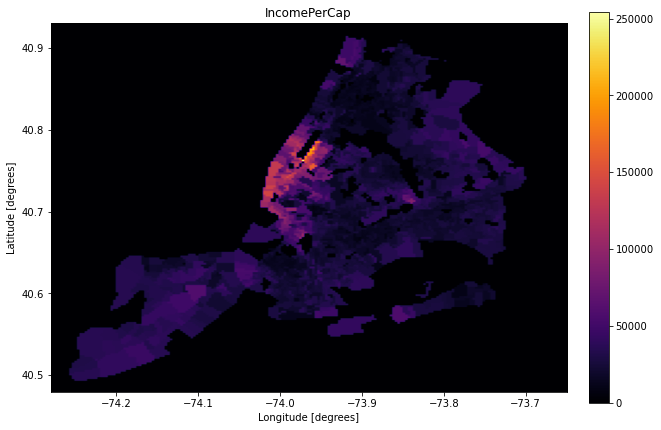

In [23]:
def make_plot(data_values,title='',colors='Greens'):
    lat_vals,lon_vals,values = convert_to_2d(blocks.Latitude,blocks.Longitude,data_values)
    fig = plt.figure(1,figsize=[10,10])
    limits = np.min(lon_vals),np.max(lon_vals),np.min(lat_vals),np.max(lat_vals)
    
    im = plt.imshow(values.T,origin='lower',cmap=colors,extent=limits)
    plt.xlabel('Longitude [degrees]')
    plt.ylabel('Latitude [degrees]')
    plt.title(title)
    plt.colorbar(im,fraction=0.035, pad=0.04)
    
    plt.show()
make_plot(blocks.IncomePerCap,colors='inferno',title='IncomePerCap')

## Crime Data

We use this data to find just Burglary crimes because we thought that other crimes like murder will not give us a reliable result because murder can happen any location and not related with that location. Burglary crimes must be related with that location so we use it. The data so huge so we filter this data just for 2019-2020 crimes.

---

In [24]:
crime_df = pd.read_csv('/kaggle/input/alldatasets/NYPD_Complaint_Data.csv', index_col=False)
crime_df=crime_df[crime_df.OFNS_DESC == "BURGLARY"]
crime_df.drop(columns = ["SUSP_AGE_GROUP","SUSP_RACE","SUSP_SEX","TRANSIT_DISTRICT","STATION_NAME","PARKS_NM","HADEVELOPT","HOUSING_PSA"],inplace = True)

crime_df = crime_df[crime_df['Latitude'].notna()]
crime_df = crime_df[crime_df['Longitude'].notna()]


crime_df.head()



CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT CMPLNT_TO_TM  \
5305   820860100   01/21/2019     04:29:00   01/22/2019     04:40:00   
5309   295998118   01/22/2019     00:00:00   01/22/2019     06:00:00   
5332   662833797   01/22/2019     07:30:00   01/22/2019     14:30:00   
5418   138156542   01/21/2019     21:00:00   01/21/2019     21:15:00   
5488   115175643   01/21/2019     19:45:00   01/22/2019     10:00:00   

      ADDR_PCT_CD      RPT_DT  KY_CD OFNS_DESC  PD_CD  ... JURISDICTION_CODE  \
5305           17  01/22/2019    107  BURGLARY    213  ...                 0   
5309           18  01/22/2019    107  BURGLARY    213  ...                 0   
5332          105  01/22/2019    107  BURGLARY    221  ...                 0   
5418          114  01/22/2019    107  BURGLARY    223  ...                 2   
5488           40  01/22/2019    107  BURGLARY    243  ...                 0   

     X_COORD_CD Y_COORD_CD   Latitude  Longitude  \
5305   992786.0   214702.0  40.755988 -73.969191   
5309   987501.0   217778.0  40.764434 -73.988266   
5332  1052322.0   203059.0  40.723773 -73.754415   
5418  1002494.0   216454.0  40.760782 -73.934145   
5488  1010503.0   236634.0  40.816151 -73.905156   

                                       Lat_Lon               PATROL_BORO  \
5305   (40.75598800500006, -73.96919089299998)     PATROL BORO MAN SOUTH   
5309        (40.76443435900006, -73.988265529)     PATROL BORO MAN SOUTH   
5332   (40.72377307100004, -73.75441510199995)  PATROL BORO QUEENS SOUTH   
5418  (40.760782095000025, -73.93414527799997)  PATROL BORO QUEENS NORTH   
5488  (40.816150608000044, -73.90515598699994)         PATROL BORO BRONX   

      VIC_AGE_GROUP                  VIC_RACE  VIC_SEX  
5305        UNKNOWN                   UNKNOWN        D  
5309        UNKNOWN                   UNKNOWN        D  
5332          25-44  ASIAN / PACIFIC ISLANDER        F  
5418          18-24                     WHITE        F  
5488        UNKNOWN                   UNKNOWN        D  

[5 rows x 27 columns]

### Create Map for Crime Locations

We use folium library to mark locations with circle in NYC map.

In [25]:
import folium

start = crime_df[['Latitude', 'Longitude']]


start.drop_duplicates(inplace=True)

m_latitude = crime_df['Latitude'].mean()
m_longitude = crime_df['Longitude'].mean()
m = folium.Map(location=[m_latitude, m_longitude])

for i, key in start.iterrows():
  latitude = key['Latitude']
  longitue = key['Longitude']
  folium.CircleMarker(
    location=[latitude, longitue],
    radius=4,
    popup='Burglary',
    color='green',
    fill=True,
    fill_color='green'
    ).add_to(m)
m

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Create Heat Map for Crime Locations

We use heat map to observe crime's density. So we can easily see that which location of NYC is more unsafe.





In [26]:
from folium import plugins

stationArr = start[['Latitude', 'Longitude']].values
m = folium.Map(location=[m_latitude, m_longitude])


plugins.HeatMap(stationArr,radius= 18).add_to(m)
m

### Ploting Borough's Crime Frequencies on Graphs

 We find borough's crime frequencies to reach which borogh's are more unsafe and plot on a graph

In [27]:
crime =crime_df["BORO_NM"].str.split('|', expand=True).stack().value_counts()
print(crime)

def Average(lst): 
    return np.sum(lst) / len(lst) 

meancrime = Average(crime)
print("Average Crime in NYC : ",meancrime)

BROOKLYN         161
MANHATTAN        131
QUEENS           112
BRONX             92
STATEN ISLAND     18
dtype: int64
Average Crime in NYC :  102.8


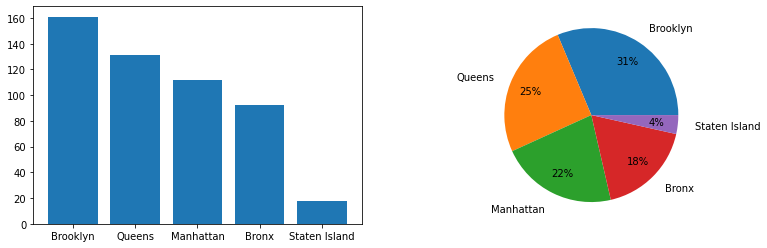

In [28]:
names= ['Brooklyn','Queens','Manhattan','Bronx','Staten Island']
values = [crime[0],crime[1],crime[2],crime[3],crime[4]]
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.bar(names,values)
plt.subplot(132)
ax_1 = plt.pie(values,labels=names, autopct='%1.0f%%', pctdistance=0.75, labeldistance=1.2)

plt.show()

We see that Brooklyn is the most burglary comitted borough with 31% and Staten Island is the least burglary comitted borough with 4%. So we see that Staten Island is the safest borough in NYC and Brooklyn is the most unsafe borough in NYC.

## Income Data


In [29]:
income_df = pd.read_csv('/kaggle/input/alldatasets/nyc_census_tracts.csv', index_col=0)
income_df = income_df[income_df['IncomePerCap'].notna()]

income_df.head()

County Borough  TotalPop   Men  Women  Hispanic  White  Black  \
CensusTract                                                                 
36005000100  Bronx   Bronx      7703  7133    570      29.9    6.1   60.9   
36005000200  Bronx   Bronx      5403  2659   2744      75.8    2.3   16.0   
36005000400  Bronx   Bronx      5915  2896   3019      62.7    3.6   30.7   
36005001600  Bronx   Bronx      5879  2558   3321      65.1    1.6   32.4   
36005001900  Bronx   Bronx      2591  1206   1385      55.4    9.0   29.0   

             Native  Asian  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  \
CensusTract                 ...                                               
36005000100     0.2    1.6  ...   NaN          NaN         NaN          NaN   
36005000200     0.0    4.2  ...   2.9          0.0         0.0         43.0   
36005000400     0.0    0.3  ...   1.4          0.5         2.1         45.0   
36005001600     0.0    0.0  ...   8.6          1.6         1.7         38.8   
36005001900     0.0    2.1  ...   3.0          2.4         6.2         45.4   

             Employed  PrivateWork  PublicWork  SelfEmployed  FamilyWork  \
CensusTract                                                                
36005000100         0          NaN         NaN           NaN         NaN   
36005000200      2308         80.8        16.2           2.9         0.0   
36005000400      2675         71.7        25.3           2.5         0.6   
36005001600      2120         75.0        21.3           3.8         0.0   
36005001900      1083         76.8        15.5           7.7         0.0   

             Unemployment  
CensusTract                
36005000100           NaN  
36005000200           7.7  
36005000400           9.5  
36005001600           8.7  
36005001900          19.2  

[5 rows x 35 columns]

We find the frequencies of Boroughs in our income data.

---



In [30]:
def county(geography):
  if "Manhattan" in geography:
    return "Manhattan"
  elif "Brooklyn" in geography:
    return "Brooklyn"
  elif "Queens" in geography:
    return "Queens"
  elif "Staten Island" in geography:
    return "Staten Island"
  elif "Bronx" in geography:
    return "Bronx"
income_df["Borough"]=income_df["Borough"].apply(county)
frequency =income_df["Borough"].str.split('|', expand=True).stack().value_counts()
print(frequency)


Brooklyn         750
Queens           646
Bronx            336
Manhattan        281
Staten Island    108
dtype: int64


### Plotting Boroughs' Frequencies on Graphs

Show which borough is repated more by plotting on a pie and bar chart.

---



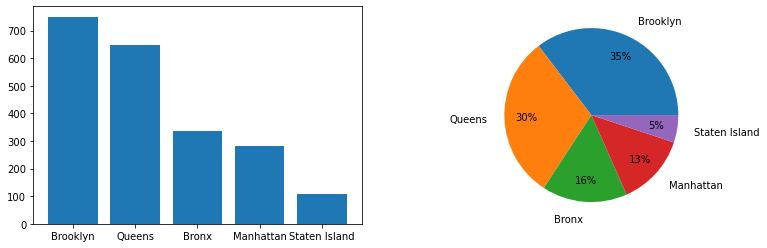

In [31]:
names= ['Brooklyn','Queens','Bronx','Manhattan','Staten Island']
values = [frequency[0],frequency[1],frequency[2],frequency[3],frequency[4]]
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.bar(names,values)
plt.subplot(132)
ax_1 = plt.pie(values,labels=names, autopct='%1.0f%%', pctdistance=0.75, labeldistance=1.2)

plt.show()

We see that Brooklyn has the most frequent   borough in the data with 35% and Staten Island is the least frequent borough with 5%.

### Plotting Boroughs Income Per Cap Difference

After we find the frequencies we find the income means for each boroughs and visualize it with bar and pie charts.

---

In [32]:
def Average(lst): 
    return np.sum(lst) / len(lst) 
brooklyn=np.array(income_df[["IncomePerCap"]][income_df["Borough"]=="Brooklyn"])
bronx=np.array(income_df[["IncomePerCap"]][income_df["Borough"]=="Bronx"])
manhattan=np.array(income_df[["IncomePerCap"]][income_df["Borough"]=="Manhattan"])
queens=np.array(income_df[["IncomePerCap"]][income_df["Borough"]=="Queens"])
statenisland=np.array(income_df[["IncomePerCap"]][income_df["Borough"]=="Staten Island"])

print("Mean of Brooklyn: ",Average(brooklyn))
print("Mean of Bronx: ",Average(bronx))
print("Mean of Manhattan: ",Average(manhattan))
print("Mean of Queens: ",Average(queens))
print("Mean of Staten Island: ",Average(statenisland))
Nycmean = (Average(brooklyn)+ Average(bronx)+Average(manhattan)+Average(queens)+Average(statenisland))/5
print("NYC Mean : " , Nycmean)

Mean of Brooklyn:  27866.530666666666
Mean of Bronx:  19481.574404761905
Mean of Manhattan:  69351.51957295374
Mean of Queens:  27596.498452012383
Mean of Staten Island:  32022.444444444445
NYC Mean :  35263.71350816783


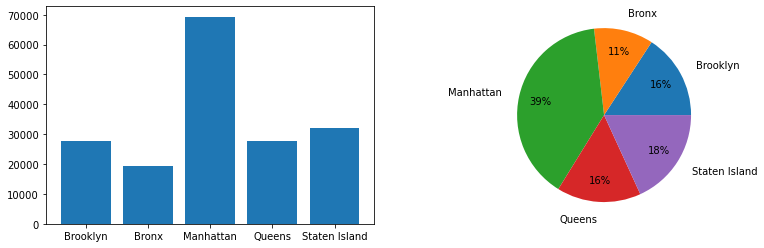

In [33]:
names= ['Brooklyn','Bronx','Manhattan','Queens','Staten Island']
values = [Average(brooklyn),Average(bronx),Average(manhattan),Average(queens),Average(statenisland)]
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.bar(names,values)
plt.subplot(132)
ax_1 = plt.pie(values,labels=names, autopct='%1.0f%%', pctdistance=0.75, labeldistance=1.2)

plt.show()

We see that Manhattan has the highest average income   borough with 39% and Bronx is the lowest average income  borough with 11%. So we see that Bronx is the poorest borough in NYC and Manhattan is the richest borough in NYC.

##  Airbnb Data

We check that which neighbourhood group is more preferred and then we calculate price mean of each borough.

In [34]:
df = pd.read_csv('/kaggle/input/alldatasets/AB_NYC_2019.csv', index_col=False)
df = df[df['latitude'].notna()]
df = df[df['longitude'].notna()]
df.head()


id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [35]:
def county(geography):
  if "Manhattan" in geography:
    return "Manhattan"
  elif "Brooklyn" in geography:
    return "Brooklyn"
  elif "Queens" in geography:
    return "Queens"
  elif "Staten Island" in geography:
    return "Staten Island"
  elif "Bronx" in geography:
    return "Bronx"
df["neighbourhood_group"]=df["neighbourhood_group"].apply(county)
frequency =df["neighbourhood_group"].str.split('|', expand=True).stack().value_counts()
print(frequency)

def Average(lst): 
    return np.sum(lst) / len(lst) 
price_brooklyn=np.array(df[["price"]][df["neighbourhood_group"]=="Brooklyn"])
price_bronx=np.array(df[["price"]][df["neighbourhood_group"]=="Bronx"])
price_manhattan=np.array(df[["price"]][df["neighbourhood_group"]=="Manhattan"])
price_queens=np.array(df[["price"]][df["neighbourhood_group"]=="Queens"])
price_statenisland=np.array(df[["price"]][df["neighbourhood_group"]=="Staten Island"])

print("Price mean of Brooklyn: ",Average(price_brooklyn))
print("Price mean of Bronx: ",Average(price_bronx))
print("Price mean of Manhattan: ",Average(price_manhattan))
print("Price mean of Queens: ",Average(price_queens))
print("Price mean of Staten Island: ",Average(price_statenisland))
NYCpricemean = (Average(price_brooklyn)+ Average(price_bronx)+Average(price_manhattan)+Average(price_queens)+Average(price_statenisland))/5
print("NYC price mean : " , NYCpricemean)



Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
dtype: int64
Price mean of Brooklyn:  124.38320732192598
Price mean of Bronx:  87.4967919340055
Price mean of Manhattan:  196.8758136743456
Price mean of Queens:  99.51764913519237
Price mean of Staten Island:  114.81233243967829
NYC price mean :  124.61715890102955


### Plotting Average Prices on Graphs

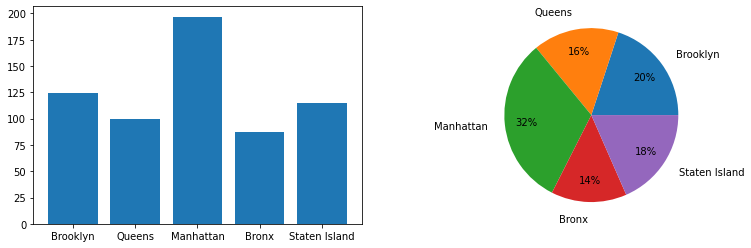

In [36]:
names= ['Brooklyn','Queens','Manhattan','Bronx','Staten Island']
values = [Average(price_brooklyn),Average(price_queens),Average(price_manhattan),Average(price_bronx),Average(price_statenisland)]
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.bar(names,values)
plt.subplot(132)
ax_1 = plt.pie(values,labels=names, autopct='%1.0f%%', pctdistance=0.75, labeldistance=1.2)

plt.show()

We see that Manhattan has the highest average prices for Airbnb hosts with 32% and Bronx is the lowest average income  borough with 14%.

### Create Heat Map for Airbnb Hosts

We use heat map to observe Airbnb hosts density. 

In [37]:
start_airbnb = df[['latitude', 'longitude']]
start_airbnb.drop_duplicates(inplace=True)
m_latitude = df['latitude'].mean()
m_longitude = df['longitude'].mean()

stationArr = start_airbnb[['latitude', 'longitude']].values
m = folium.Map(location=[m_latitude, m_longitude])


plugins.HeatMap(stationArr,radius= 15).add_to(m)
m

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Create Map for Airbnb Host Locations

We pick 1000 of that locations because data is too huge to mark on map so we pick randomly.

In [38]:
df= df.iloc[1:40000:40]
print(df.shape)
start_airbnb = df[['latitude', 'longitude']]


start_airbnb.drop_duplicates(inplace=True)

m_latitude = df['latitude'].mean()
m_longitude = df['longitude'].mean()
m = folium.Map(location=[m_latitude, m_longitude])

for i, key in start_airbnb.iterrows():
  latitude = key['latitude']
  longitue = key['longitude']
  folium.CircleMarker(
    location=[latitude, longitue],
    radius=4,
    popup='AirBnB',
    color='green',
    fill=True,
    fill_color='blue'
    ).add_to(m)
m

(1000, 16)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Null and Alternative Hypotheses (Crime - Airbnb)

$ H_0: $ The number of burglary committed in the borough smaller than 102.8,Airbnb prices will equals the mean of Airbnb prices.

$ H_1: $  The number of burglary committed in the borough smaller than 102.8  will smaller than the mean of Airbnb prices.


We read data again because we changed its' size earlier when we mapping.

In [40]:
df = pd.read_csv('/kaggle/input/alldatasets/AB_NYC_2019.csv',index_col=False)
df = df[df['latitude'].notna()]
df = df[df['longitude'].notna()]
df.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [43]:
def county(geography):
  if "Manhattan" in geography:
    return "Manhattan"
  elif "Brooklyn" in geography:
    return "Brooklyn"
  elif "Queens" in geography:
    return "Queens"
  elif "Staten Island" in geography:
    return "Staten Island"
  elif "Bronx" in geography:
    return "Bronx"
df["neighbourhood_group"]=df["neighbourhood_group"].apply(county)
frequency =df["neighbourhood_group"].str.split('|', expand=True).stack().value_counts()
print(frequency)

def Average(lst): 
    return np.sum(lst) / len(lst) 
price_brooklyn=np.array(df[["price"]][df["neighbourhood_group"]=="Brooklyn"])
price_bronx=np.array(df[["price"]][df["neighbourhood_group"]=="Bronx"])
price_manhattan=np.array(df[["price"]][df["neighbourhood_group"]=="Manhattan"])
price_queens=np.array(df[["price"]][df["neighbourhood_group"]=="Queens"])
price_statenisland=np.array(df[["price"]][df["neighbourhood_group"]=="Staten Island"])

print("Price mean of Brooklyn: ",Average(price_brooklyn))
print("Price mean of Bronx: ",Average(price_bronx))
print("Price mean of Manhattan: ",Average(price_manhattan))
print("Price mean of Queens: ",Average(price_queens))
print("Price mean of Staten Island: ",Average(price_statenisland))
NYCpricemean = (Average(price_brooklyn)+ Average(price_bronx)+Average(price_manhattan)+Average(price_queens)+Average(price_statenisland))/5
print("NYC price mean : " , NYCpricemean)


Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
dtype: int64
Price mean of Brooklyn:  124.38320732192598
Price mean of Bronx:  87.4967919340055
Price mean of Manhattan:  196.8758136743456
Price mean of Queens:  99.51764913519237
Price mean of Staten Island:  114.81233243967829
NYC price mean :  124.61715890102955


Calculate one tailed t test for our hypothesis.

In [44]:
sample_mean = (price_bronx[0]+price_statenisland[0])/2
mean_test = NYCpricemean

df=df[df.neighbourhood_group != "Manhattan"]
df=df[df.neighbourhood_group != "Queens"]
df=df[df.neighbourhood_group != "Brooklyn"]



samplearray = []
samplearray.append(price_bronx[0])
samplearray.append(price_statenisland[0])

n = 3

S = np.std(df["price"])
t_score = (sample_mean-mean_test)/(S/np.sqrt(n))
t_score = t_score/2
print(t_score)


[-0.35899919]


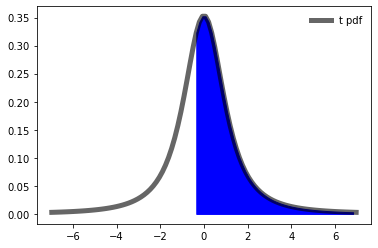

In [45]:
from scipy.stats import t

fig, ax = plt.subplots(1, 1)
df = n-1
x = np.linspace(t.ppf(0.01, df),t.ppf(0.99, df), 100)
first = t_score
last = max(x)
ax.plot(x, t.pdf(x, df),'k-', lw=5, alpha=0.6, label='t pdf')
ax.legend(loc='best', frameon=False)
plt.fill_between(x, t.pdf(x,df), where=(x>=first)&(x<last), color='b')

plt.show()

### P value

Calculate p value for our hypothesis.

In [46]:
from scipy import stats
# your code
temp=[]
temp = stats.ttest_1samp(samplearray, mean_test)
print(temp)


Ttest_1sampResult(statistic=array([-4.64114393]), pvalue=array([0.13510328]))




P value is 0.13 which is bigger than 0.05 = 𝛼. 0.13 > 0.05 so we fail to reject null hypothesis, we accept it.




## Null and Alternative Hypotheses(Income - Airbnb)

$ H_0: $ Income of borough smaller than 35263, Airbnb prices will equals the mean of Airbnb prices.

$ H_1: $  Income of borough smaller than 35263, Airbnb prices will smaller than mean of Airbnb prices.


We read data again because we changed it at on earlier t test.

In [47]:
df = pd.read_csv('/kaggle/input/alldatasets/AB_NYC_2019.csv', index_col=False)
df = df[df['latitude'].notna()]
df = df[df['longitude'].notna()]
df.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [48]:
def county(geography):
  if "Manhattan" in geography:
    return "Manhattan"
  elif "Brooklyn" in geography:
    return "Brooklyn"
  elif "Queens" in geography:
    return "Queens"
  elif "Staten Island" in geography:
    return "Staten Island"
  elif "Bronx" in geography:
    return "Bronx"
df["neighbourhood_group"]=df["neighbourhood_group"].apply(county)
frequency =df["neighbourhood_group"].str.split('|', expand=True).stack().value_counts()
print(frequency)

def Average(lst): 
    return np.sum(lst) / len(lst) 
price_brooklyn=np.array(df[["price"]][df["neighbourhood_group"]=="Brooklyn"])
price_bronx=np.array(df[["price"]][df["neighbourhood_group"]=="Bronx"])
price_manhattan=np.array(df[["price"]][df["neighbourhood_group"]=="Manhattan"])
price_queens=np.array(df[["price"]][df["neighbourhood_group"]=="Queens"])
price_statenisland=np.array(df[["price"]][df["neighbourhood_group"]=="Staten Island"])

print("Price mean of Brooklyn: ",Average(price_brooklyn))
print("Price mean of Bronx: ",Average(price_bronx))
print("Price mean of Manhattan: ",Average(price_manhattan))
print("Price mean of Queens: ",Average(price_queens))
print("Price mean of Staten Island: ",Average(price_statenisland))
NYCpricemean = (Average(price_brooklyn)+ Average(price_bronx)+Average(price_manhattan)+Average(price_queens)+Average(price_statenisland))/5
print("NYC price mean : " , NYCpricemean)


Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
dtype: int64
Price mean of Brooklyn:  124.38320732192598
Price mean of Bronx:  87.4967919340055
Price mean of Manhattan:  196.8758136743456
Price mean of Queens:  99.51764913519237
Price mean of Staten Island:  114.81233243967829
NYC price mean :  124.61715890102955


Calculate one tailed t test for our hypothesis.

In [49]:
samp_mean = (price_brooklyn[0]+price_queens[0]+price_bronx[0]+price_statenisland[0])/4

mean_te = NYCpricemean


df=df[df.neighbourhood_group != "Manhattan"]


samp = []
samp.append(price_brooklyn[0])
samp.append(price_bronx[0])
samp.append(price_queens[0])
samp.append(price_statenisland[0])

n = 3

St = np.std(df["price"])

t_value = (samp_mean-mean_te)/(St/np.sqrt(n))
t_value = t_value/2
print(t_value)


[-0.13000961]


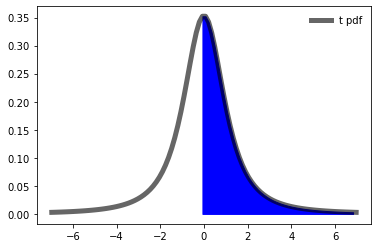

In [50]:
from scipy.stats import t
fig, ax = plt.subplots(1, 1)
df = n-1
x = np.linspace(t.ppf(0.01, df),t.ppf(0.99, df), 100)
first = t_value
last = max(x)
ax.plot(x, t.pdf(x, df),'k-', lw=5, alpha=0.6, label='t pdf')
ax.legend(loc='best', frameon=False)
plt.fill_between(x, t.pdf(x,df), where=(x>=first)&(x<last), color='b')

plt.show()

### P value Calculate p value for our hypothesis.

P value



In [51]:
from scipy import stats
# your code
k=[]
k = stats.ttest_1samp(samp, mean_te)
print(k)


Ttest_1sampResult(statistic=array([-1.07544664]), pvalue=array([0.36096655]))



P value is 0.36 which is bigger than 0.05 = 𝛼. 0.36 > 0.05 so we fail to reject null hypothesis, we accept it.

## Use New and Old Data for ML


### Add New Columns to Airbnb Data

For getting better result in machine learning algorithms we use income and crime data and in addition to that we find the same Airbnb 2019 data's more detailed form and merge some columns from that data to our Airbnb data.

We dropped rows which has a column with NaN value for make it usable in our machine learning model.


In [57]:
df = pd.read_csv('/kaggle/input/alldatasets/AB_NYC_2019.csv', index_col=False)
newdata = pd.read_csv('/kaggle/input/alldatasets/listings-3.csv')
newdata = newdata[['id','review_scores_rating']]
newdata2=df.merge(newdata, on='id')
newdata2=newdata2.dropna(how="any")
df=newdata2


###Label Price

We will use supervised machine learning technique which is called classification. So that we converted our continious data type to discrete data type. When we examine our data we see that price which are bigger than 1000 $ are outliers. The outliers are 0.4% of our data and we prevent manipulation of our data. 

We divide Airbnb prices into 5 categories (1-200, 201-400, 401-600, 601-800, 801-1000).


In [58]:
def pricecategories(price):
  pricem=price['price']
  for i in range(5):
    if (i *200 < pricem) & ( pricem<=i*200+200):
      return i
      
df = df[df['latitude'].notna()]
df = df[df['longitude'].notna()]
df=df.loc[df.price<1000]
df = df.loc[df.price > 0]


df["label"]=df.apply(pricecategories,axis=1)
df.head()

id                                       name  host_id    host_name  \
0  2595                      Skylit Midtown Castle     2845     Jennifer   
1  3831            Cozy Entire Floor of Brownstone     4869  LisaRoxanne   
2  5099  Large Cozy 1 BR Apartment In Midtown East     7322        Chris   
3  5121                            BlissArtsSpace!     7356        Garon   
4  5178           Large Furnished Room Near B'way      8967     Shunichi   

  neighbourhood_group       neighbourhood  latitude  longitude  \
0           Manhattan             Midtown  40.75362  -73.98377   
1            Brooklyn        Clinton Hill  40.68514  -73.95976   
2           Manhattan         Murray Hill  40.74767  -73.97500   
3            Brooklyn  Bedford-Stuyvesant  40.68688  -73.95596   
4           Manhattan      Hell's Kitchen  40.76489  -73.98493   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt    225               1                 45  2019-05-21   
1  Entire home/apt     89               1                270  2019-07-05   
2  Entire home/apt    200               3                 74  2019-06-22   
3     Private room     60              45                 49  2017-10-05   
4     Private room     79               2                430  2019-06-24   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.38                               2               355   
1               4.64                               1               194   
2               0.59                               1               129   
3               0.40                               1                 0   
4               3.47                               1               220   

   review_scores_rating  label  
0                  94.0      1  
1                  89.0      0  
2                  90.0      0  
3                  90.0      0  
4                  84.0      0

###Crime Close to Host

We realize that when we give all neighbourhood the same crime rate it will not fit our project because we want to investigate crimes which are close to our host. In a neighbourhood there can be diversity of their crime rates because of that we do not generalize it.

We divide difference of latitudes and difference of longitudes with 10. So that we create a elliptical shape to find crimes which are close that host. Farlong represents our y-radius of elliptical shape and farlat represents our x-radius of elliptical shape. So we acquire a data which is extracted from "crime data" and then we create a column with using this data to add inside to airbnb data.


In [59]:
minlat = df["latitude"].min(axis=0)
minlong= df["longitude"].min(axis=0)
maxlat = df["latitude"].max(axis=0)
maxlong = df["longitude"].max(axis=0)
farlat = (maxlat-minlat)/10 
farlong=(maxlong-minlong)/10
print("The min latitude is {}".format(df["latitude"].min(axis=0)))
print("The min longitude is {}".format(df["longitude"].min(axis=0)))
print("The max latitude is {}".format(df["latitude"].max(axis=0)))
print("The max longitude is {}".format(df["longitude"].max(axis=0)))
print("Differences between latitudes is {}".format(farlat*10))
print("Differences between longitudes is {}".format(farlong*10))


sizelist=[]
for i,j in zip(df["latitude"],df["longitude"]):
  size=crime_df.loc[(crime_df["Latitude"]> i-farlat) &(crime_df["Latitude"]<i+farlat) &(crime_df["Longitude"]>j-farlong) &(crime_df["Longitude"]<j+farlong)].shape[0]
  sizelist.append(size)
df["near_crime"] = sizelist

The min latitude is 40.50868
The min longitude is -74.23986
The max latitude is 40.90804
The max longitude is -73.71299
Differences between latitudes is 0.3993600000000015
Differences between longitudes is 0.5268699999999882


### Average Income for the Area Close to Host

We realize that when we give all neighbourhood the same average income rate it will not fit our project because we want to investigate average income which are close to our host. In a neighbourhood there can be diversity of their average income because of that we do not generalize it.

We divide difference of latitudes and difference of longitudes with 10. So that we create a elliptical shape to find average income which are close that host. Farlong represents our y-radius of elliptical shape and farlat represents our x-radius of elliptical shape. So we acquire a data which is extracted from "income data" and then we create a column with using this data to add inside to airbnb data.

In [60]:
incomelist=[]
for i,j in zip(df["latitude"],df["longitude"]):
  size=blocks.loc[(blocks["Latitude"]>i-farlat) &(blocks["Longitude"]<i+farlat) &(blocks["Longitude"]>j-farlong) &(blocks["Longitude"]<j+farlong)]
  meansize=size["IncomePerCap"].mean(axis=0)
  incomelist.append(meansize)
df["near_income"] = incomelist

### Visualize Relation of Crime and Average Income

We plot the relation of crime and average income into a scatter. We conclude that they are well fit for classification model and we think there will no underfitting or overfitting problem, it resembles appropriate fitting.

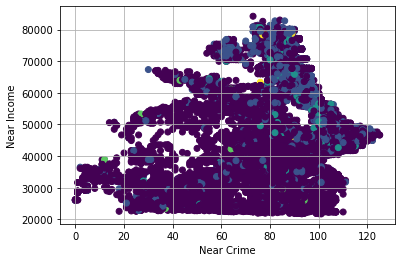

In [61]:
plt.scatter(df["near_crime"], df["near_income"], c=df["label"])
plt.xlabel("Near Crime")
plt.ylabel("Near Income")
plt.grid()
plt.show()


## Machine Learning Algorithms with 2 Features

In this machine learning part, we investigated the effect of crime and income features with different classification models and determining our categorized price label.


### Implementation
We used KNN model with normalization and find the best features for KNN model we used Grid Search method.Also,We used Decision Tree,Random Forest Algorithm and Gaussian Naive Bayes.

#### Hyperparameter Tunning with KNN

Number of neighbors will effect of our model preformance so we want to optimize our model. So that we plot it into a grap for 15 K value and we realize that after k = 6 it does not have a big impact our accuracy score.

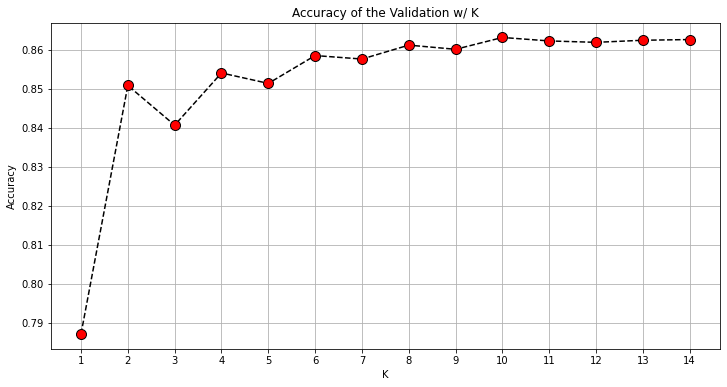

[0.7871048401500268, 0.8508662261118057, 0.8406858367565637, 0.8540810859081979, 0.851402036077871, 0.8585461689587426, 0.8576531523486337, 0.8612252187890694, 0.8601535988569388, 0.8631898553313092, 0.8622968387212002, 0.8619396320771566, 0.862475442043222, 0.8626540453652438]


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

X =df[["near_crime","near_income"]]
y =df["label"]
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.20, random_state=0)
K_range = np.arange(1, 15)
before = []
for k in K_range:
  model = KNeighborsClassifier(k)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_remaining)
  accuracy = accuracy_score(y_pred,y_remaining)
  before.append(accuracy)
plt.figure(figsize=(12, 6))  
plt.plot(K_range, before, color='black', linestyle='dashed', marker='o',  
         markerfacecolor='red', markersize=10)
plt.title('Accuracy of the Validation w/ K')  
plt.xlabel('K')  
plt.ylabel('Accuracy')
plt.xticks(K_range)
plt.grid()
plt.show()


print(before)


#### Grid Search

We use grid search in our knn algorithm so that we found best leaf size, best distance calculation algorithm(manhattan) and best k value for knn model but our leaf leaf range is 1 to 10 we can not find the best leaf size(actually best is 30).

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
leaf_size = list(range(1,10))
n_neighbors = list(range(1,15))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X,y)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])


Best leaf_size: 4
Best p: 1
Best n_neighbors: 14


In [64]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=14,p=1,leaf_size=14)
model.fit(X_train, y_train)
y_pred = model.predict(X_remaining)
accuracy = accuracy_score(y_pred,y_remaining)
accuracy

0.8626540453652438

#### Standart Scaler of KNN 
It arranges the data in a standard normal distribution.
We think that it is useful in our classification problem which preventing differing ranges may cause a problem. 

Standardization is only effects 0.002 because we think our features are not obtained from differing ranges due to their definitions.

In [65]:
scaler = StandardScaler()
X2 = scaler.fit_transform(X)
y2 = LabelEncoder().fit_transform(y)
X_train2, X_remaining2, y_train2, y_remaining2 = train_test_split(X2, y2, test_size=0.20, random_state=0)


after = []

model = KNeighborsClassifier(k)
model.fit(X_train2, y_train2)
y_pred2 = model.predict(X_remaining2)
accuracy = accuracy_score(y_pred2,y_remaining2)
print(accuracy)


0.8642614752634399


#### Decision Tree
We used the Decision Tree because we think that it is proper for our classification problem.We use cross validation method for 1-10 max depth values and visualize accuracy scores into a graph to show best max_depth parameter in range 10.

We found the best max_depth is 4 because we think our features are not complicated and simplicity is best so that we can keep our tree small.In each split step,it gives highest information.So that,max_depth did not grow so much.


In [66]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

accuracy_list = []
accuracy_SD_list = []

for depth in range (1, 10):
  model = tree.DecisionTreeClassifier(max_depth=depth)
  accuracies_CV = cross_val_score(model, X_train, y_train, cv=5)
  accuracy_list.append(accuracies_CV.mean())
  accuracy_SD_list.append(accuracies_CV.std())

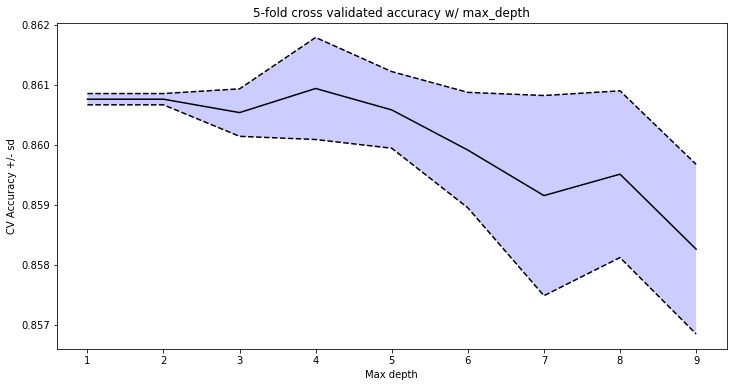

[0.8607600692467783, 0.8607600692467783, 0.8605367552673231, 0.8609386207143434, 0.8605813682052148, 0.8599115160112483, 0.8591523880834993, 0.8595096306210284, 0.858259211938478]


In [67]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 10), accuracy_list, color='black', linestyle='solid')
plt.plot(range(1, 10), np.array(accuracy_list) + np.array(accuracy_SD_list),color='black', linestyle='dashed')
plt.plot(range(1, 10), np.array(accuracy_list) - np.array(accuracy_SD_list),color='black', linestyle='dashed' )
plt.fill_between(range(1, 10), np.array(accuracy_list) + np.array(accuracy_SD_list),
                 np.array(accuracy_list) - np.array(accuracy_SD_list), alpha=0.2, facecolor ='b')
plt.plot()
plt.title('5-fold cross validated accuracy w/ max_depth')  
plt.xlabel('Max depth')  
plt.ylabel('CV Accuracy +/- sd') 
plt.show()
print(accuracy_list)

#### Standarization of decision tree for max_depth 

We observe that standarization should have no impact on the performance of a decision tree. It is generally useful, when you are solving a system of equations, least squares, etc, where we can have serious issues due to rounding errors. In decision tree, we are just comparing stuff and branching down the tree, so standarization would not help.



In [68]:
 model = tree.DecisionTreeClassifier(max_depth=4)
 accuracies_CV = cross_val_score(model, X_train2, y_train2, cv=5)
 accuracies_CV.mean()

0.8609386207143434

#### Random Forest Algorithm 

Random forest method does not have big impact for the accuracy score when we compare with other ML models.Because Random Forest Algorithm has the power to handle a large data set with higher dimensionality.We do not provide high dimensional data to our model.

In [69]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
rf_predictions = model_rf.predict(X_remaining)
rf_acc = accuracy_score(y_remaining, rf_predictions)
print("Random Forest Accuracy:"+str(rf_acc))


Random Forest Accuracy:0.8447937131630648


#### Standarization of Random Forest Algorithm 

Standarization does not have big effect on our accuracy score.It is because same reason which explained in Decision Tree standarization.

In [70]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train2, y_train2)
rf_predictions = model_rf.predict(X_remaining2)
rf_acc = accuracy_score(y_remaining2, rf_predictions)
print("Random Forest Accuracy:"+str(rf_acc))


Random Forest Accuracy:0.8449723164850866


#### Gaussian Naive Bayes
When the predictors take up a continuous value and are not discrete, we assume that these values are sampled from a gaussian distribution.We observe the best accuracy score in Bayes model.Normalization does not effect the our accuracy score because  it will just rescale the features in this case but the probabilities will remain the same.

In [71]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_remaining)
accuracy_score(y_remaining, y_pred)

0.8660475084836577

In [72]:
clf = GaussianNB()
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_remaining2)
accuracy_score(y_remaining2, y_pred)


0.8660475084836577

### Results & Discussion
<table>
  <thead>
    <tr>
      <th>Machine Learning Model</th>
      <th>Raw Features</th>
      <th>Standardized Features</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>KNN</td>
      <td>0.86318</td>
      <td>0.86426</td>
    </tr>
    <tr>
      <td>Decision Tree</td>
      <td>0.86058</td>
      <td>0.86093</td>
    </tr> 
    <tr>
      <td>Random Forest</td>
      <td>0.84479</td>
      <td>0.84497</td>
    </tr>
    <tr>
      <td>Gaussian Naive Bayes</td>
      <td>0.86604</td>
      <td>0.86604</td>
    </tr>
  </tbody>
</table>

In KNN model we get good accuracy score because our classes are quite separable.We used scatter plot and so it is clear that our classes are more linearly seperable.Standarization of KNN doesnt effect so much because  differing ranges are not high between 2 data feature.In 2 features,Decision tree worked well because of our simplicity of features.There is no high dimensinality only two features effect on our label.It worked better than Random forest because  decision tree is better when the dataset have a feature that is really important to take a decision and Random Forest model worked well when more number of feature existed.In Decision Tree and Random forest tree , we are just comparing stuff and branching down the tree, so standarization would not have big impact on our Standarized feature's accuracy score.We find the our crime rate and income datas are independent from each other in our Null Hypothesis tests.So that,we expect the Naive bayes will give good accuracy score because it works well in independent features.We observed the highest accuracy score in Gaussian Naive Bayes as expected result.

## Machine Learning Algorithms with more features

We add 4 more features to our previous machine learning models.Our aim is to find more accurate result.Also,we want to see that how the new features affect in determining price category.

We use extra 3 datasets in addition to our original Airbnb dataset for new features.These datasets are Crime dataset,Income dataset,modified Airbnb dataset which is more detailed version of our Airbnb dataset.Categorized distance column was created by our distance calculation.It explained in detail below.Also room types are converted into integer values.




#### Categorized Distance Column Creation

We aim to see effect of distance to center in determining the Airbnb prices.So that we categorized the our Airbnb house into 3 different categories.0 represent closest points to our borough's center.2 represents the farest point to our borough's center.


Center of Manhattan =40.7831° latitude, -73.9712° longitude 

Center of Brooklyn =40.6782° latitude, -73.9442° longitude

Center of Bronx =40.8448° latitude, -73.8648° longitude 

Center of Queens =40.7282° latitude, -73.7949° longitude 

Center of Staten Island =40.5795° latitude, -74.1502° longitude 

In [73]:
import math
def euclideandistance(x,y,m1,m2):
  return math.sqrt(sum([(x - m1) ** 2+(y-m2)**2]))



In [74]:
euclideandistance=[euclideandistance(i,j,40.7831,-73.9712) for i,j in zip(df["latitude"],df["longitude"])]
a=np.array(euclideandistance)
df["Center Distance"]=a
df.neighbourhood_group.unique()
import numpy as np

def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x
selection_sort(a)

manhattandistances=df["Center Distance"][df.neighbourhood_group=="Manhattan"]
brooklyndistances=df["Center Distance"][df.neighbourhood_group=="Brooklyn"]
queensdistances=df["Center Distance"][df.neighbourhood_group=="Queens"]
StatenIslanddistances=df["Center Distance"][df.neighbourhood_group=="Staten Island"]
Bronxdistances=df["Center Distance"][df.neighbourhood_group=="Bronx"]

manhattandistancesarray=np.array(manhattandistances)
brooklyndistancessarray=np.array(brooklyndistances)
queensdistancessarray=np.array(queensdistances)
StatenIslanddistancessarray=np.array(StatenIslanddistances)
Bronxdistancessarray=np.array(Bronxdistances)

selection_sort(manhattandistancesarray)
selection_sort(brooklyndistancessarray)
selection_sort(queensdistancessarray)
selection_sort(StatenIslanddistancessarray)
selection_sort(Bronxdistancessarray)

print(manhattandistancesarray.shape)
print(brooklyndistancessarray.shape)
print(queensdistancessarray.shape)
print(StatenIslanddistancessarray.shape)
print(Bronxdistancessarray.shape)

def categorizedistance(row):
  centerdistance=row["Center Distance"]
  neighbourhoodgrp=row["neighbourhood_group"]
  if neighbourhoodgrp=="Manhattan":
    if centerdistance<0.03049026729957918:
      return 0
    elif (0.03049026729957918< centerdistance) and (centerdistance<0.05446495019734937):
      return 1
    else:
      return 2
  if neighbourhoodgrp=="Brooklyn":
    if centerdistance<0.0937867463984107:
      return 0
    elif (0.0937867463984107< centerdistance) and (centerdistance<0.11028837880755411):
      return 1
    else:
      return 2
  if neighbourhoodgrp=="Queens":
    if centerdistance<0.06712938924197284:
      return 0
    elif (0.06712938924197284< centerdistance) and (centerdistance<0.1396300845090239):
      return 1
    else:
      return 2
  if neighbourhoodgrp=="Staten Island":
    if centerdistance<0.1915125909698905:
      return 0
    elif (0.1915125909698905< centerdistance) and (centerdistance<0.21802457132167005):
      return 1
    else:
      return 2
  if neighbourhoodgrp=="Bronx":
    if centerdistance<0.09245849068635675:
      return 0
    elif (0.09245849068635675< centerdistance) and (centerdistance<0.13281655657333968):
      return 1
    else:
      return 2
df["Categorized Distance"]=df.apply(categorizedistance,axis=1)

(11714,)
(12089,)
(3303,)
(217,)
(669,)


#### Encoding Room Type Column

There are 3 different types of room type.So we converted them into integer form to use in model which expect numeric inputs.

In [75]:
df["room_type"].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [76]:
def classifyfunc(room_type):
  if room_type=="Entire home/apt":
    return 0
  elif room_type=="Private room":
    return 1
  elif room_type=="Shared room":
    return 2
df["room_type"]=df["room_type"].apply(classifyfunc)

### Implementation
We used KNN model with normalization and find the best features for KNN model.Also,We used Decision Tree,Random Forest Algorithm and Gaussian Naive Bayes.

#### Hyperparameter Tunning with KNN

Number of neighbors will effect of our model preformance so we want to optimize our model. So that we plot it into a grap for 15 K value and we realize that after k = 4 it does not have a big impact our accuracy score.

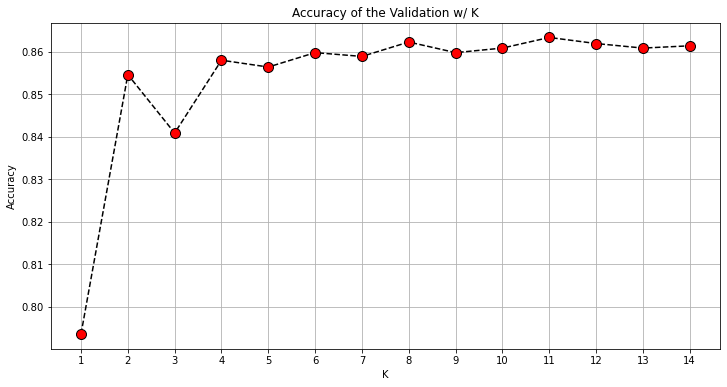

[0.7935345597428112, 0.8546168958742633, 0.8408644400785854, 0.8580103589926773, 0.8564029290944811, 0.8597963922128952, 0.8589033756027862, 0.8622968387212002, 0.8597963922128952, 0.860868012145026, 0.863368458653331, 0.8619396320771566, 0.860868012145026, 0.8614038221110912]


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

X =df[["near_crime","near_income","number_of_reviews","review_scores_rating","Categorized Distance","room_type"]]
y =df["label"]
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.20, random_state=0)
K_range = np.arange(1, 15)
before = []
for k in K_range:
  model = KNeighborsClassifier(k)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_remaining)
  accuracy = accuracy_score(y_pred,y_remaining)
  before.append(accuracy)
plt.figure(figsize=(12, 6))  
plt.plot(K_range, before, color='black', linestyle='dashed', marker='o',  
         markerfacecolor='red', markersize=10)
plt.title('Accuracy of the Validation w/ K')  
plt.xlabel('K')  
plt.ylabel('Accuracy')
plt.xticks(K_range)
plt.grid()
plt.show()


print(before)

#### Standart Scaler
It arranges the data in a standard normal distribution.
We think that it is useful in our classification problem which preventing differing ranges may cause a problem. 

Standardization is only effects 0.0034 because we think our features are not obtained from differing ranges due to their definitions.

In [78]:
scaler = StandardScaler()
X2 = scaler.fit_transform(X)
y2 = LabelEncoder().fit_transform(y)
X_train2, X_remaining2, y_train2, y_remaining2 = train_test_split(X2, y2, test_size=0.20, random_state=0)


after = []

model = KNeighborsClassifier(k)
model.fit(X_train2, y_train2)
y_pred2 = model.predict(X_remaining2)
accuracy = accuracy_score(y_pred2,y_remaining2)
print(accuracy)


0.8672977317378103


#### Decision Tree
We used the Decision Tree because we think that it is proper for our classification problem.We use cross validation method for 1-10 max depth values and visualize accuracy scores into a graph to show best max_depth parameter in range 10.

We found the best max_depth is 4 because we think our features are not complicated and simplicity is best so that we can keep our tree small.In each split step,it gives highest information.So that,max_depth did not grow so much.

In [79]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

accuracy_list = []
accuracy_SD_list = []

for depth in range (1, 10):
  model = tree.DecisionTreeClassifier(max_depth=depth)
  accuracies_CV = cross_val_score(model, X_train, y_train, cv=5)
  accuracy_list.append(accuracies_CV.mean())
  accuracy_SD_list.append(accuracies_CV.std())
print(accuracy_list)

[0.8607600692467783, 0.8607600692467783, 0.8607600692467783, 0.8607600692467783, 0.8595097602518269, 0.8591973001693877, 0.8554460740365366, 0.8540171238296208, 0.8520966634927063]


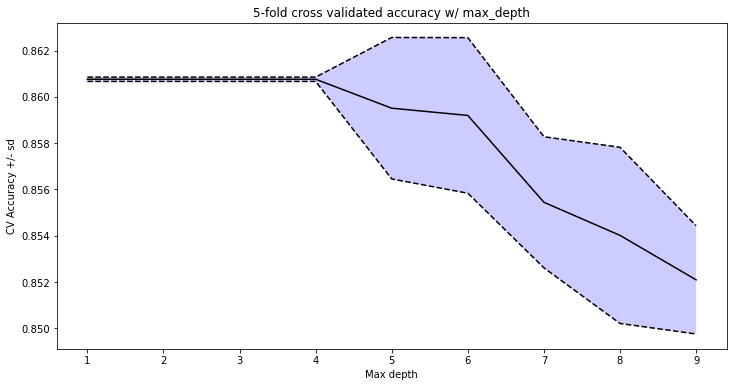

In [80]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 10), accuracy_list, color='black', linestyle='solid')
plt.plot(range(1, 10), np.array(accuracy_list) + np.array(accuracy_SD_list),color='black', linestyle='dashed')
plt.plot(range(1, 10), np.array(accuracy_list) - np.array(accuracy_SD_list),color='black', linestyle='dashed' )
plt.fill_between(range(1, 10), np.array(accuracy_list) + np.array(accuracy_SD_list),
                 np.array(accuracy_list) - np.array(accuracy_SD_list), alpha=0.2, facecolor ='b')
plt.plot()
plt.title('5-fold cross validated accuracy w/ max_depth')  
plt.xlabel('Max depth')  
plt.ylabel('CV Accuracy +/- sd') 
plt.show()

#### Standarization of decision tree for max_depth 

We observe that standarization should have no impact on the performance of a decision tree. It is generally useful, when you are solving a system of equations, least squares, etc, where we can have serious issues due to rounding errors. In decision tree, we are just comparing stuff and branching down the tree, so standarization would not help.


In [81]:
 model = tree.DecisionTreeClassifier(max_depth=6)
 accuracies_CV = cross_val_score(model, X_train2, y_train2, cv=5)
 accuracies_CV.mean()

0.8591526473450966

#### Random Forest Algorithm 

Random Forest Algorithm has the power to handle a large data set with higher dimensionality.When we compare with first machine learning part which has only 2 features,now we have better accuracy score , it has higher dimensionality because Random forest model works better with more features.

In [82]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
rf_predictions = model_rf.predict(X_remaining)
rf_acc = accuracy_score(y_remaining, rf_predictions)
print("Random Forest Accuracy:"+str(rf_acc))


Random Forest Accuracy:0.8542596892302197


In [83]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train2, y_train2)
rf_predictions = model_rf.predict(X_remaining2)
rf_acc = accuracy_score(y_remaining2, rf_predictions)
print("Random Forest Accuracy:"+str(rf_acc))


Random Forest Accuracy:0.8549741025183069


#### Gaussian Naive Bayes
When the predictors take up a continuous value and are not discrete, we assume that these values are sampled from a gaussian distribution.Normalization does not effect the our accuracy score because  it will just rescale the featues in this case but the probabilities will remain the same.

When we compare with first machine learning part with 2 features now our accuracy score decreased because model lose efficiency in high dimensional spaces – namely when the number of features increases.



In [84]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_remaining)
accuracy_score(y_remaining, y_pred)

0.8467583497053045

In [85]:
clf = GaussianNB()
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_remaining2)
accuracy_score(y_remaining2, y_pred)
#standardization etkilemedi gaussianNB

0.8224682979103412

### Results & Discussion
<table>
  <thead>
    <tr>
      <th>Machine Learning Model</th>
      <th>Raw Features</th>
      <th>Standardized Features</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>KNN</td>
      <td>0.862114</td>
      <td>0.865868</td>
    </tr>
    <tr>
      <td>Decision Tree</td>
      <td>0.860729</td>
      <td>0.862491</td>
    </tr> 
    <tr>
      <td>Random Forest</td>
      <td>0.849791</td>
      <td>0.850828</td>
    </tr>
    <tr>
      <td>Gaussian Naive Bayes</td>
      <td>0.850866</td>
      <td>0.850866</td>
    </tr>
  </tbody>
</table>

In KNN model we get good accuracy score because our classes are quite separable.It is clear that our classes are more linearly seperable.Standarization of KNN doesnt effect so much because differing ranges are not high between 6 data feature.In 6 features.When KNN model used with more features, the differening between the values increased, so the standarization gave a more effective result compared to 2 features in 6 features.Decision tree worked well because of our simplicity of features.There is no high dimensinality only six features effect on our label.It worked better than Random forest because decision tree is better when the dataset have a feature that is really important to take a decision and Random Forest model worked well when more number of feature existed.In Decision Tree and Random forest tree , we are just comparing stuff and branching down the tree, so standarization would not have big impact on our Standarized feature's accuracy score.With the increasing number of feature,Random forest model gives better accuracy score because it work better with higher number of feature.More number of features decreasing the independence between the features so that with comparing 2 features Naive Bayes the accuracy score decreased as we expected.

##Conclusion
In our first machine learning part, we achieved a high accuracy score with only 2 features.With our hypothesis tests, we understood that our income and crime data are not dependent with our Airbnb data. However, when using these 2 datas together, airbnb prices can predict the price categories with an accuracy score of up to 86%.Then we added 4 more features to 2 features which we think might affect the price category but it does not give big impact on accuracy score.

We think our solution is applicable because we have good accuracy score.

Our one of the most important advantages of our solution is high accuracy score which can be used in Airbnb Company.However,we have 14% margin of error so it can be considered as a disadvantage that it does not give a definite result. 



